In [ ]:
import MetaTrader5 as mt5
from datetime import datetime
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import talib
import seaborn as sns
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
import random

D:\Anaconda3\envs\PythonFinancas\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.5 when it was built against 1.10.6, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)
pd.set_option('mode.chained_assignment', None)

config = tf.compat.v1.ConfigProto(gpu_options =
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [ ]:
ativo = 'PETR4'
mt5.initialize()
mt5.symbol_select(ativo)

In [ ]:
df = mt5.copy_rates_from_pos(ativo, mt5.TIMEFRAME_D1, 0, 5000)
df = pd.DataFrame(df)
df['time'] = pd.to_datetime(df['time'], unit = 's')
df = df.set_index('time') #tempo em index
df

In [5]:
df['return'] = np.log(df['close']/df['close'].shift(1))
df.dropna(inplace=True)
df

,open,high,low,close,tick_volume,spread,real_volume,return
time,,,,,,,,
2006-07-04,16.05,16.15,15.90,15.95,2173,0,2619500,-0.006250
2006-07-05,15.77,15.92,15.54,15.73,4623,0,6400800,-0.013889
2006-07-06,15.88,15.96,15.80,15.91,3668,0,6371200,0.011378
2006-07-07,15.99,15.99,15.67,15.77,3185,0,5947600,-0.008838
2006-07-10,15.78,15.83,15.57,15.75,2490,0,3767800,-0.001269
...,...,...,...,...,...,...,...,...
2021-03-15,23.11,23.71,23.10,23.65,81590,0,67874000,0.020505
2021-03-16,23.63,23.68,23.23,23.34,58841,0,43405200,-0.013194
2021-03-17,23.14,24.13,23.11,24.04,102302,0,77966400,0.029550


In [6]:
cols =[]
lags = 5
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    df[col] = df['return'].shift(lag)
    cols.append(col)
df.dropna(inplace=True)
df

,open,high,low,close,tick_volume,spread,real_volume,return,lag_1,lag_2,lag_3,lag_4,lag_5
time,,,,,,,,,,,,,
2006-07-11,15.70,16.19,15.56,16.19,4520,0,7501500,0.027553,-0.001269,-0.008838,0.011378,-0.013889,-0.006250
2006-07-12,16.09,16.32,16.05,16.10,4441,0,6194800,-0.005574,0.027553,-0.001269,-0.008838,0.011378,-0.013889
2006-07-13,16.01,16.11,15.91,16.01,3092,0,4552100,-0.005606,-0.005574,0.027553,-0.001269,-0.008838,0.011378
2006-07-14,16.10,16.32,16.08,16.21,4152,0,6251100,0.012415,-0.005606,-0.005574,0.027553,-0.001269,-0.008838
2006-07-17,16.16,16.31,15.54,15.63,6141,0,8747000,-0.036436,0.012415,-0.005606,-0.005574,0.027553,-0.001269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15,23.11,23.71,23.10,23.65,81590,0,67874000,0.020505,-0.005166,0.041645,0.034149,0.022957,-0.059341
2021-03-16,23.63,23.68,23.23,23.34,58841,0,43405200,-0.013194,0.020505,-0.005166,0.041645,0.034149,0.022957
2021-03-17,23.14,24.13,23.11,24.04,102302,0,77966400,0.029550,-0.013194,0.020505,-0.005166,0.041645,0.034149


In [7]:
df['direction'] = np.where(df['return'] > 0, 1, 0)
variaveis_uteis = ['close', 'return', 'direction'] + cols
df_new = df[variaveis_uteis]
df_new

,close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
time,,,,,,,,
2006-07-11,16.19,0.027553,1,-0.001269,-0.008838,0.011378,-0.013889,-0.006250
2006-07-12,16.10,-0.005574,0,0.027553,-0.001269,-0.008838,0.011378,-0.013889
2006-07-13,16.01,-0.005606,0,-0.005574,0.027553,-0.001269,-0.008838,0.011378
2006-07-14,16.21,0.012415,1,-0.005606,-0.005574,0.027553,-0.001269,-0.008838
2006-07-17,15.63,-0.036436,0,0.012415,-0.005606,-0.005574,0.027553,-0.001269
...,...,...,...,...,...,...,...,...
2021-03-15,23.65,0.020505,1,-0.005166,0.041645,0.034149,0.022957,-0.059341
2021-03-16,23.34,-0.013194,0,0.020505,-0.005166,0.041645,0.034149,0.022957
2021-03-17,24.04,0.029550,1,-0.013194,0.020505,-0.005166,0.041645,0.034149


In [8]:
optimizer = Adam(learning_rate=0.0001)
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

In [9]:
model = Sequential()
model.add(Dense(64,
                activation= 'relu',
                input_shape= (lags, )))
model.add(Dense(64,
                activation='relu'))
model.add(Dense(1,
                activation= 'sigmoid'))
model.compile(optimizer = optimizer,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [10]:
cutoff = '2020-09-01'

In [11]:
training_data = df_new[df_new.index < cutoff].copy()
media = training_data.mean()
desvio = training_data.std()
training = (training_data - media)/ desvio
training

,close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
time,,,,,,,,
2006-07-11,-0.536654,0.931905,1.001288,-0.046514,-0.303200,0.382851,-0.474959,-0.215653
2006-07-12,-0.550646,-0.192407,-0.998428,0.931773,-0.046273,-0.303345,0.382751,-0.474967
2006-07-13,-0.564639,-0.193468,-0.998428,-0.192650,0.932042,-0.046422,-0.303511,0.382745
2006-07-14,-0.533544,0.418123,1.001288,-0.193710,-0.192413,0.931876,-0.046563,-0.303519
2006-07-17,-0.623719,-1.239808,-0.998428,0.417941,-0.193474,-0.192559,0.931830,-0.046571
...,...,...,...,...,...,...,...,...
2020-08-25,0.497244,-0.240136,-0.998428,0.652173,-0.213186,-0.241750,-0.225498,0.621839
2020-08-26,0.399296,-0.952503,-0.998428,-0.240383,0.652434,-0.213332,-0.241910,-0.225505
2020-08-27,0.385303,-0.141023,-0.998428,-0.952820,-0.240148,0.652273,-0.213489,-0.241917


In [12]:
test_data = df_new[df_new.index >= cutoff].copy()
test = (test_data - media) / desvio
test

,close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
time,,,,,,,,
2020-09-01,0.492580,1.316571,1.001288,-0.828723,0.544770,-0.141169,-0.952968,-0.240461
2020-09-02,0.503463,0.100775,1.001288,1.316476,-0.828504,0.544610,-0.141320,-0.952976
2020-09-03,0.500353,-0.032896,-0.998428,0.100561,1.316757,-0.828639,0.544526,-0.141327
2020-09-04,0.498799,-0.018066,-0.998428,-0.033123,0.100807,1.316583,-0.828857,0.544520
2020-09-08,0.408624,-0.875798,-0.998428,-0.018292,-0.032882,0.100655,1.316575,-0.828865
...,...,...,...,...,...,...,...,...
2021-03-15,0.623177,0.692685,1.001288,-0.178776,1.410361,1.155730,0.775810,-2.017872
2021-03-16,0.574980,-0.451019,-0.998428,0.692529,-0.178539,1.410186,1.155706,0.775804
2021-03-17,0.683812,0.999683,1.001288,-0.451286,0.692792,-0.178685,1.410187,1.155701


In [13]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs = 50,
          verbose= True,
          validation_split= 0.2,
          shuffle= False)

Epoch 1/50
88/88 [==============================] - 3s 16ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.4914
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.4918 - val_loss: 0.6930 - val_accuracy: 0.4914

In [14]:
res = pd.DataFrame(model.history.history)
res

,loss,accuracy,val_loss,val_accuracy
0,0.693194,0.499821,0.693137,0.491429
1,0.693079,0.498034,0.693049,0.491429
2,0.693004,0.503754,0.692961,0.492857
3,0.692939,0.508759,0.692883,0.500000
4,0.692873,0.514480,0.692806,0.500000
5,0.692813,0.516267,0.692733,0.505714
6,0.692756,0.525206,0.692669,0.507143
7,0.692691,0.526636,0.692603,0.508571
8,0.692627,0.524491,0.692540,0.514286
9,0.692567,0.527708,0.692484,0.514286


<AxesSubplot:>

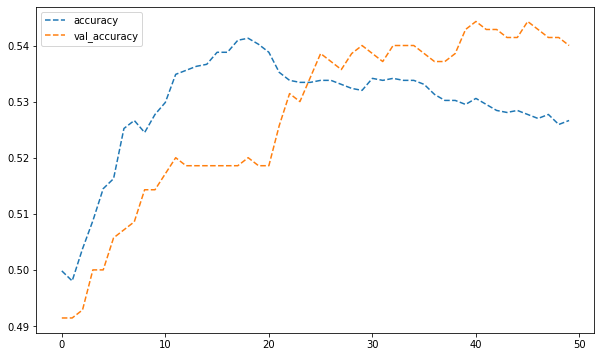

In [15]:
res[['accuracy', 'val_accuracy']].plot(figsize = (10,6), style = '--')

In [16]:
model.evaluate(training[cols], training_data['direction'])

110/110 [==============================] - 0s 3ms/step - loss: 0.8330 - accuracy: 0.5339


[0.8329797387123108, 0.533886194229126]

<AxesSubplot:xlabel='time'>

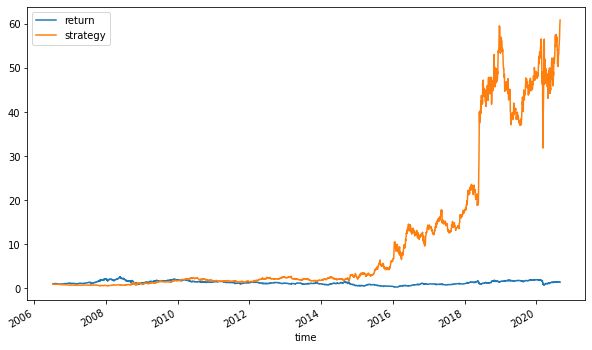

In [18]:
pred = np.where(model.predict(training[cols]) > 0.5, 1, 0)
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] * training_data['return'])
training_data[['return', 'strategy']].sum().apply(np.exp)
training_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize = (10,6))

5/5 [==============================] - 0s 4ms/step - loss: 1.0629 - accuracy: 0.4030


<AxesSubplot:xlabel='time'>

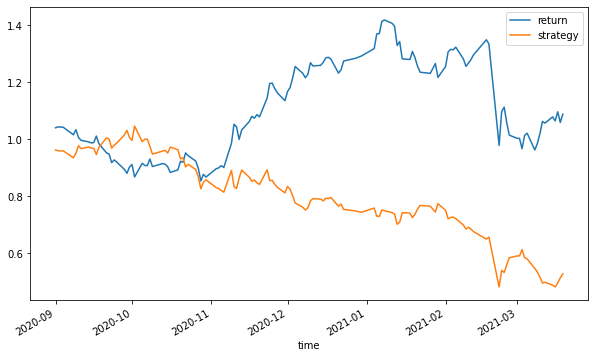

In [21]:
model.evaluate(test[cols], test_data['direction'])
pred = np.where(model.predict(test[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['strategy'] = (test_data['prediction'] * test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)
test_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize = (10,6))